In [1]:
import os
import numpy as np
import h5py

In [2]:
import torch

In [3]:
import librosa as lc

In [4]:
import matplotlib.pyplot as plt

In [7]:
data = "/media/gagan/Extreme SSD/zudeep/all_birds.hdf"

In [8]:
data = h5py.File(data, "r")

In [9]:
type(data)

h5py._hl.files.File

In [10]:
data_keys = list(data.keys())

In [11]:
len(data_keys)

1438117

In [12]:
data_keys[213512]

'idx_1192162_2011-02-10_r15s12U-f0559-2011-2-10-8-26-2.wav_21'

In [14]:
data_keys[-10]

'idx_999995_Box4_LB5_UD_LB5_43535.37804683_3_11_10_30_4.wav_28'

In [65]:
def from_polar(image):
    ''' Get complex spectrogram from polar coordinate '''
    return image[:, :, 0]*np.cos(image[:, :, 1]) + 1j*image[:,:,0]*np.sin(image[:,:,1])


def transform(im):
    """
    This function should be used to transform data into the desired format for the network.
    inverse transoform should be an inverse of this function
    """
    im = from_polar(im)
    im, phase = lc.magphase(im)
    #im = np.log1p(im)
    return im

def rescale_spectrogram(s, eps=0.1):
    ''' Just to make a 
        brighter spectrogram     
    '''
    if np.min(s) < 0:
        s = s - np.min(s) 
    s = s/np.max(s)
    return np.log(s + eps)

In [132]:
n = str(np.random.choice(data_keys, size=1)[0])
n


'idx_351934_Box6_AQ2_M6M7_LIME30_43348.47997461_9_5_13_19_57.wav_4'

In [133]:
d = np.array(data[n])
d.shape

(129, 47, 2)

In [134]:
d = rescale_spectrogram(transform(d), eps=0.01)

In [135]:
d.shape

(129, 47)

In [136]:
d.min()

-4.605170185988091

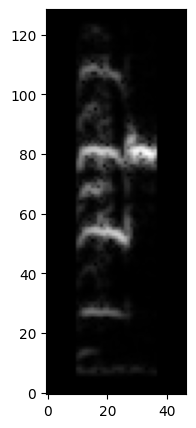

In [137]:
plt.figure(figsize=(15,5))
plt.imshow(d, origin="lower", cmap="gray")

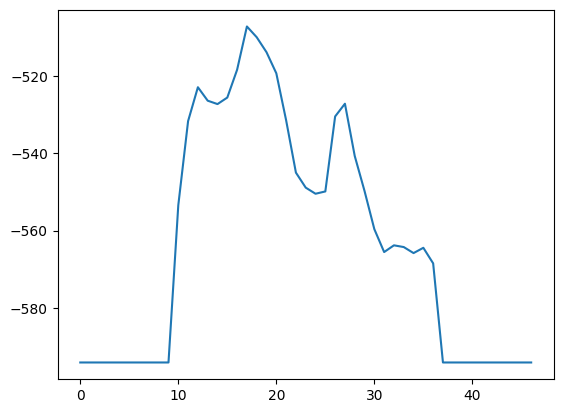

In [138]:
plt.plot(d.sum(axis=0))

# Encodec

In [11]:
from datasets import load_dataset, Audio
from transformers import EncodecModel, AutoProcessor

/home/gagan/anaconda3/envs/audio_trainer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import transformers

In [13]:
transformers.__version__

'4.31.0.dev0'

In [14]:
# load the model + processor (for pre-processing the audio)
model = EncodecModel.from_pretrained("facebook/encodec_24khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [15]:
import librosa

In [16]:
y, sr = librosa.load("/media/gagan/Gagan_external/songbird_data/WAV_files/b3g20/SAP/tutor/songs/b3g20D-f00213-2.wav", sr=24000)

In [17]:
y.shape

(30817,)

In [26]:
# pre-process the inputs
inputs = processor(raw_audio=y, sampling_rate=processor.sampling_rate, return_tensors="pt")

In [86]:
# explicitly encode then decode the audio inputs
with torch.no_grad():
    encoder_outputs = model.encode(inputs["input_values"], inputs["padding_mask"], bandwidth=24.)
    audio_values = model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]

In [117]:
encoder_outputs.keys()

odict_keys(['audio_codes', 'audio_scales'])

In [118]:
encoder_outputs["audio_codes"].shape

torch.Size([1, 1, 32, 97])

In [119]:
encoder_outputs["audio_codes"].squeeze()

tensor([[865, 121, 463,  ..., 865, 121,  62],
        [424, 913, 860,  ..., 424, 518, 424],
        [678, 678, 918,  ..., 678, 678, 786],
        ...,
        [832, 853, 756,  ..., 419, 321, 321],
        [893, 322, 507,  ..., 461, 601, 525],
        [580, 977, 823,  ..., 777, 939, 611]])

In [87]:
audio_values = audio_values.squeeze()
yhat = audio_values.numpy()
yhat.shape

(30817,)

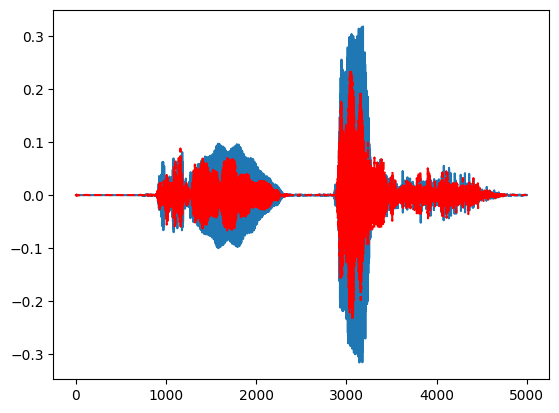

In [88]:
plt.plot(y[:5000])
plt.plot(yhat[:5000],'--r')

In [48]:
from IPython.display import display, Audio

In [89]:
display(Audio(y, rate=24000))

In [90]:
display(Audio(yhat, rate=24000))

In [30]:
from torchaudio import transforms

In [120]:
m = transforms.Spectrogram(n_fft=512, win_length=256, hop_length=128)

In [121]:
y_spec = m(torch.from_numpy(y)).numpy()

In [122]:
y_spec.shape

(257, 241)

In [123]:
y_spec2 = m(torch.from_numpy(yhat)).numpy()

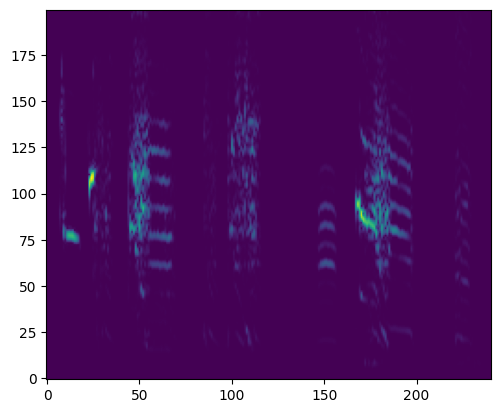

In [124]:
plt.imshow(rescale_spectrogram(y_spec[:200,:],0.001), origin="lower")

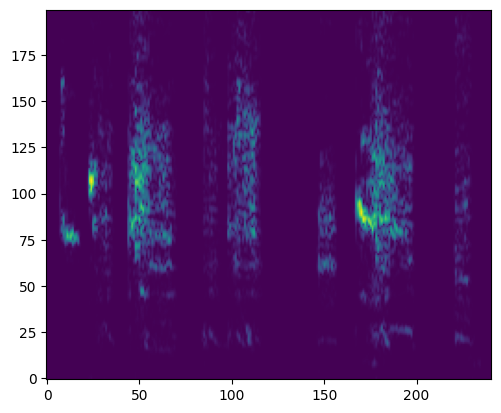

In [125]:
plt.imshow(rescale_spectrogram(y_spec2[:200,:],0.001), origin="lower")

# Create a new dataset with huggingface datasets

In [5]:
# Let's start with only our birds

In [6]:
birds = ["b3g20", "b4g20", "b6r17", "b7r16", "b8r17", "b14r16", "b13r16", "g7r15",
         "g19r15", "g20r15", "k3r16", "k6r16", "p3r16", "p20r16", "r15s12", "r15y2", "r15y5"]


tutors = ["g1p2", "g10o15", "b12r14", "b13r14", "p7r13", "r14y2", "b12r14", "b12p14",
          "r14y2", "b13r14", "p7r13", "b9r14", "p7r13", "p7r13", "b12r14", "b12r14", "p7r13"]

start_dph = [45, 38, 37, 39, 38, 37, 38, 39,
             38, 39, 44, 45, 39, 48, 40, 37, 37]

tutoring_start_date = [47, 47, 51, 47, 51, 47, 47, 38,
                       39, 38, 47, 47, 44, 46, 38, 43, 41]

In [7]:
bird_data = { k: {"bird_name": k, "tutor_name": t, "start_dph": d, "tutoring_start_dph": x} for (k, t, d, x) in zip(birds, tutors, start_dph, tutoring_start_date)}

In [8]:
bird_data

{'b3g20': {'bird_name': 'b3g20',
  'tutor_name': 'g1p2',
  'start_dph': 45,
  'tutoring_start_dph': 47},
 'b4g20': {'bird_name': 'b4g20',
  'tutor_name': 'g10o15',
  'start_dph': 38,
  'tutoring_start_dph': 47},
 'b6r17': {'bird_name': 'b6r17',
  'tutor_name': 'b12r14',
  'start_dph': 37,
  'tutoring_start_dph': 51},
 'b7r16': {'bird_name': 'b7r16',
  'tutor_name': 'b13r14',
  'start_dph': 39,
  'tutoring_start_dph': 47},
 'b8r17': {'bird_name': 'b8r17',
  'tutor_name': 'p7r13',
  'start_dph': 38,
  'tutoring_start_dph': 51},
 'b14r16': {'bird_name': 'b14r16',
  'tutor_name': 'r14y2',
  'start_dph': 37,
  'tutoring_start_dph': 47},
 'b13r16': {'bird_name': 'b13r16',
  'tutor_name': 'b12r14',
  'start_dph': 38,
  'tutoring_start_dph': 47},
 'g7r15': {'bird_name': 'g7r15',
  'tutor_name': 'b12p14',
  'start_dph': 39,
  'tutoring_start_dph': 38},
 'g19r15': {'bird_name': 'g19r15',
  'tutor_name': 'r14y2',
  'start_dph': 38,
  'tutoring_start_dph': 39},
 'g20r15': {'bird_name': 'g20r15',
 

Each record in the dataset should have the following structure:

1. bird_name
2. recording_date
3. days_post_hatch
4. filename
5. audio  # array of floats, downsampled / no resampling
6. spectrogram  # array of floats
7. nfft
8. window_length # samples
9. window_overlap
10. sample_rate
11. tutor_name
12. tutoring_start_date
13. tutored  # bool

In [9]:
COLUMNS = ["bird_name", "recording_date", "days_post_hatch", "filename", "audio", "spectrogram", "sample_rate",
           "n_fft", "win_length", "hop_length", "tutor_name", "tutoring_start_dph", "tutored"]

In [10]:
from datasets import Dataset, concatenate_datasets
import os
import shutil
from dataclasses import dataclass, field
from typing import List, Tuple, Dict
import librosa
import glob
import asyncio

In [11]:
import datetime

In [12]:
import pdb

In [16]:
@dataclass
class BirdsongHFDatasetBuilder:

    path_to_all_birds: str
    output_dir: str
    bird_metadata: dict
    original_sample_rate: int = 32000
    target_sample_rate: int = 16000
    n_fft: int = 256
    win_length: int = 256
    hop_length: int = 128
    batch_write_size: int = 2000
    log_every: int = 500
    folder_stepin_1: str = "SAP"
    folder_stepin_2: str = "songs"
    extention: str = "wav"
    columns: List[str] = field(default_factory=lambda: COLUMNS)
    
    def __post_init__(self):
        self.results = {k: [] for k in self.columns}
        self.curr_num_samples = 0
        self._tmp_first_date = None
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        
    def _write_batch(self, batch_number: int):
        # make a hugginface Dataset
        dataset = Dataset.from_dict(self.results)
        # save dataset to disk
        dataset.save_to_disk(os.path.join(self.output_dir,
                                  f"dataset_{batch_number}"))
        # reset results
        self.results = {k: [] for k in self.columns}

    def _load_and_concatenate_datasets(self):
        # load all datasets
        datasets = []
        for i in range(self.num_batches):
            dataset = Dataset.load_from_disk(os.path.join(self.output_dir, f"dataset_{i}"))
            datasets.append(dataset)
        # concatenate datasets
        dataset = concatenate_datasets(datasets)
        # save dataset to disk
        print(f"..... Saving dataset to disk .....")
        dataset.save_to_disk(self.output_dir)
        # remove all temporary datasets
        for i in range(self.num_batches):
            shutil.rmtree(join(self.output_dir, f"dataset_{i}"))
        return dataset

    async def _create_sample(self, path_to_file: str, 
                       recording_date: str, 
                       dph: int,
                       bird_data: Dict) -> None:
        # load the file
        y, _ = librosa.load(path_to_file, sr=self.target_sample_rate)
        
        # create spectrogram
        S = librosa.stft(y, n_fft=self.n_fft, 
                         win_length=self.win_length,
                         hop_length=self.hop_length)
        S = np.abs(S)
        if "tutor" in recording_date:
            # this is tutor bird
            bird_name = bird_data["bird_name"] + "_tutor"
        else:
            bird_name = bird_data["bird_name"]
        self.results["bird_name"].append(bird_name)
        self.results["recording_date"].append(recording_date)
        self.results["days_post_hatch"].append(dph)
        self.results["filename"].append(os.path.basename(path_to_file))
        self.results["audio"].append(y)
        self.results["spectrogram"].append(S)
        self.results["sample_rate"].append(self.target_sample_rate)
        self.results["n_fft"].append(self.n_fft)
        self.results["win_length"].append(self.win_length)
        self.results["hop_length"].append(self.hop_length)
        self.results["tutor_name"].append(bird_data["tutor_name"])
        self.results["tutoring_start_dph"].append(bird_data["tutoring_start_dph"])
        self.results["tutored"].append(dph >= bird_data["tutoring_start_dph"])
        self.curr_num_samples += 1
        
    async def _create_samples(self, folder_path: str, index: int, bird_data: Dict):
        # list all files
        recording_date = os.path.basename(folder_path)
        if "tutor" in recording_date:
            dph = -1
        else:
            # convert to datetime first
            date = datetime.datetime.strptime(recording_date, "%Y-%m-%d")
            if index == 0:
                dph = bird_data["start_dph"]
                self._tmp_first_date = date
            else:
                # calculate dph by difference to tmp first date
                dph = bird_data["start_dph"] + (date - self._tmp_first_date).days

        all_file_paths = glob.glob(os.path.join(folder_path, self.folder_stepin_2, "*" + self.extention))

        for f in all_file_paths:
            await self._create_sample(f, recording_date, dph, bird_data) 
            
            if (self.curr_num_samples + 1) % self.log_every == 0:
                    print(f'..... {self.curr_num_samples} samples created .....')
            # write a batch of samples to disk
            if len(self.results["bird_name"]) >= self.batch_write_size:
                self._write_batch(self.num_batches)
                self.num_batches += 1
                print(f'### {self.num_batches} batches written .....#####')
            
    def _list_folder_paths(self, bird_name: str):
        day_folders = sorted(glob.glob(os.path.join(self.path_to_all_birds, bird_name, self.folder_stepin_1, "20*")))
        tutor_folder = glob.glob(os.path.join(self.path_to_all_birds, bird_name, self.folder_stepin_1, "tutor"))[0]
        return day_folders, tutor_folder

    async def _make_files(self, day_folders: str, tutor_folder: str, bird_data: Dict) -> None:
        for i, folder_path in enumerate(day_folders):
            await self._create_samples(folder_path, i, bird_data)
        # await asyncio.gather(*(self._create_samples(day_folders[i], i, bird_data) for i in range(len(day_folders))))
        self._create_samples(tutor_folder, -1, bird_data)
        
    async def build_dataset(self):

        birds = list(self.bird_metadata.keys())
        
        self.num_batches = 0  # keep track of the number of batches written
        for j, bird in enumerate(birds):
            
            print(f"\nProcessing birds {bird}\n\n")
            bird_data = self.bird_metadata[bird]
            day_folders, tutor_folder = self._list_folder_paths(bird)
            print(f"Found {len(day_folders)} days for this bird")
            await self._make_files(day_folders, tutor_folder, bird_data)
            
        # write the last batch
        self._write_batch(self.num_batches)
        # concatenate all batches into a single dataset
        return self._load_and_concatenate_datasets()

In [17]:
async def main():
    builder = BirdsongHFDatasetBuilder(path_to_all_birds="/media/gagan/Gagan_external/songbird_data/WAV_files",
                                    output_dir="/media/gagan/Gagan_external/songbird_data/hf_dataset",
                                    bird_metadata=bird_data,
                                    original_sample_rate=32000,
                                    target_sample_rate=16000,
                                    n_fft=256,
                                    win_length=256,
                                    hop_length=128,
                                    batch_write_size=2000,
                                    log_every=500)
    await builder.build_dataset()                            

In [ ]:
await main()


Processing birds b3g20


Found 78 days for this bird
..... 499 samples created .....
..... 999 samples created .....
..... 1499 samples created .....
..... 1999 samples created .....


Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

### 1 batches written .....#####
..... 2499 samples created .....
..... 2999 samples created .....
..... 3499 samples created .....
..... 3999 samples created .....


Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

### 2 batches written .....#####
..... 4499 samples created .....
..... 4999 samples created .....
..... 5499 samples created .....
..... 5999 samples created .....


Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

### 3 batches written .....#####
..... 6499 samples created .....
..... 6999 samples created .....
..... 7499 samples created .....
..... 7999 samples created .....


Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

### 4 batches written .....#####
